# DATA FOUNDATION & BASELINE METRICS
## Olist Seller Churn Analysis - Proof of Concept

**Objectives:**
1. Build core dataset linking MQLs → Deals → Sellers → Orders
2. Define churn metrics
3. Calculate baseline seller activity metrics
4. Create cohort retention analysis

### Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set visualization style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

### STEP 1: Load All Datasets

**Note:** Update the `data_path` variable below to point to your data directory.

In [2]:
# Data folder
data_path = '/home/cairo/code/portfolio/olist-ecommerce/data/raw/'  # Current directory, or use absolute path like '/path/to/data/'

# Output folder
output_path = "/home/cairo/code/portfolio/olist-ecommerce/output/poc/"

# Marketing funnel data
mqls = pd.read_csv(f'{data_path}olist_marketing_qualified_leads_dataset.csv')
deals = pd.read_csv(f'{data_path}olist_closed_deals_dataset.csv')

# Core operational data
sellers = pd.read_csv(f'{data_path}olist_sellers_dataset.csv')
orders = pd.read_csv(f'{data_path}olist_orders_dataset.csv')
order_items = pd.read_csv(f'{data_path}olist_order_items_dataset.csv')
products = pd.read_csv(f'{data_path}olist_products_dataset.csv')
customers = pd.read_csv(f'{data_path}olist_customers_dataset.csv')
reviews = pd.read_csv(f'{data_path}olist_order_reviews_dataset.csv')
payments = pd.read_csv(f'{data_path}olist_order_payments_dataset.csv')

# Translation
category_translation = pd.read_csv(f'{data_path}product_category_name_translation.csv')

print("Dataset Loaded:")
print(f"✓ MQLs: {len(mqls):,} records")
print(f"✓ Closed Deals: {len(deals):,} records")
print(f"✓ Sellers: {len(sellers):,} records")
print(f"✓ Orders: {len(orders):,} records")
print(f"✓ Order Items: {len(order_items):,} records")
print(f"✓ Products: {len(products):,} records")
print(f"✓ Customers: {len(customers):,} records")
print(f"✓ Reviews: {len(reviews):,} records")
print(f"✓ Payments: {len(payments):,} records")

Dataset Loaded:
✓ MQLs: 8,000 records
✓ Closed Deals: 842 records
✓ Sellers: 3,095 records
✓ Orders: 99,441 records
✓ Order Items: 112,650 records
✓ Products: 32,951 records
✓ Customers: 99,441 records
✓ Reviews: 99,224 records
✓ Payments: 103,886 records


### STEP 2: Data Quality Check

In [3]:
print("📋 CLOSED DEALS DATASET STRUCTURE:")
print("\nFirst 5 rows:")
display(deals.head())

print("\nColumn Types:")
print(deals.dtypes)

print("\nMissing Values:")
missing = deals.isnull().sum()
print(missing[missing > 0])

📋 CLOSED DEALS DATASET STRUCTURE:

First 5 rows:


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0



Column Types:
mql_id                               str
seller_id                            str
sdr_id                               str
sr_id                                str
won_date                             str
business_segment                     str
lead_type                            str
lead_behaviour_profile               str
has_company                       object
has_gtin                          object
average_stock                        str
business_type                        str
declared_product_catalog_size    float64
declared_monthly_revenue         float64
dtype: object

Missing Values:
business_segment                   1
lead_type                          6
lead_behaviour_profile           177
has_company                      779
has_gtin                         778
average_stock                    776
business_type                     10
declared_product_catalog_size    773
dtype: int64


In [4]:
# Parse dates
deals['won_date'] = pd.to_datetime(deals['won_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

print("✓ Date parsing complete")
print(f"  Deal date range: {deals['won_date'].min()} to {deals['won_date'].max()}")
print(f"  Order date range: {orders['order_purchase_timestamp'].min()} to {orders['order_purchase_timestamp'].max()}")

✓ Date parsing complete
  Deal date range: 2017-12-05 02:00:00 to 2018-11-14 18:04:19
  Order date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18


### STEP 3: Build Seller Master Dataset

In [5]:
# Start with deals (842 sellers who closed)
seller_master = deals.copy()

# Merge with MQL data to get lead source and funnel info
seller_master = seller_master.merge(
    mqls[['mql_id', 'first_contact_date', 'landing_page_id', 'origin']],
    on='mql_id',
    how='left'
)

# Parse first_contact_date
seller_master['first_contact_date'] = pd.to_datetime(seller_master['first_contact_date'])

# Calculate sales cycle length
seller_master['sales_cycle_days'] = (
    seller_master['won_date'] - seller_master['first_contact_date']
).dt.days

# Merge with sellers table to get location
seller_master = seller_master.merge(
    sellers[['seller_id', 'seller_city', 'seller_state']],
    on='seller_id',
    how='left'
)

print(f"✓ Seller Master Dataset: {len(seller_master)} sellers")
print(f"  {seller_master['seller_id'].notna().sum()} have seller_id")

display(seller_master.head())

✓ Seller Master Dataset: 842 sellers
  842 have seller_id


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin,sales_cycle_days,seller_city,seller_state
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,5,belo horizonte,MG
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,34,NaN,NaN
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,63,novo hamburgo,RS
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,3,NaN,NaN
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,267,santos,SP


### STEP 4: Calculate Seller Activity Metrics

In [6]:
# Get all order items by seller
seller_orders = order_items.merge(
    orders[['order_id', 'order_purchase_timestamp', 'order_status', 'customer_id']],
    on='order_id',
    how='inner'
)

# Filter to delivered/completed orders only
completed_statuses = ['delivered', 'shipped', 'approved', 'invoiced']
seller_orders = seller_orders[seller_orders['order_status'].isin(completed_statuses)]

print(f"✓ Total order items: {len(order_items):,}")
print(f"✓ Order items with order data: {len(seller_orders):,}")
print(f"✓ Completed orders only: {len(seller_orders):,}")

# Calculate seller-level metrics
seller_activity = seller_orders.groupby('seller_id').agg({
    'order_id': 'nunique',  # unique orders
    'customer_id': 'nunique',  # unique customers
    'price': ['sum', 'mean'],  # total GMV and AOV
    'order_purchase_timestamp': ['min', 'max']  # first and last sale
}).reset_index()

# Flatten column names
seller_activity.columns = [
    'seller_id', 'total_orders', 'unique_customers', 
    'total_gmv', 'avg_order_value', 'first_sale_date', 'last_sale_date'
]

# Calculate activity span
seller_activity['days_active'] = (
    seller_activity['last_sale_date'] - seller_activity['first_sale_date']
).dt.days + 1

# Dataset end date (for recency calculation)
dataset_end_date = orders['order_purchase_timestamp'].max()
seller_activity['days_since_last_sale'] = (
    dataset_end_date - seller_activity['last_sale_date']
).dt.days

print(f"\n✓ Seller activity metrics calculated for {len(seller_activity):,} sellers")
print(f"  Dataset end date: {dataset_end_date}")

display(seller_activity.head())

✓ Total order items: 112,650
✓ Order items with order data: 111,744
✓ Completed orders only: 111,744

✓ Seller activity metrics calculated for 2,987 sellers
  Dataset end date: 2018-10-17 17:30:18


,seller_id,total_orders,unique_customers,total_gmv,avg_order_value,first_sale_date,last_sale_date,days_active,days_since_last_sale
0,0015a82c2db000af6aaaf3ae2ecb0532,3,3,2685.00,895.000000,2017-09-26 22:17:05,2017-10-18 08:16:34,22,364
1,001cca7ae9ae17fb1caed9dfb1094831,200,200,25080.03,104.937364,2017-02-04 19:06:04,2018-07-12 21:38:26,524,96
2,002100f778ceb8431b7a1020ff7ab48f,51,51,1234.50,22.445455,2017-09-14 01:00:31,2018-04-12 12:58:23,211,188
3,003554e2dce176b5555353e4f3555ac8,1,1,120.00,120.000000,2017-12-15 06:52:25,2017-12-15 06:52:25,1,306
4,004c9cd9d87a3c30c522c48c4fc07416,158,158,19712.71,115.957118,2017-01-27 10:34:34,2018-05-03 11:13:38,462,167


### STEP 5: Merge Activity & Define Churn Metrics

In [7]:
# Merge activity metrics
seller_master = seller_master.merge(
    seller_activity,
    on='seller_id',
    how='left'
)

# Calculate time to first sale
seller_master['days_to_first_sale'] = (
    seller_master['first_sale_date'] - seller_master['won_date']
).dt.days

# Fill NaN for sellers with no sales
seller_master['total_orders'] = seller_master['total_orders'].fillna(0)
seller_master['total_gmv'] = seller_master['total_gmv'].fillna(0)

# CHURN DEFINITIONS
# 1. Never-activated: 0 orders within 90 days of won_date
seller_master['never_activated'] = (
    (seller_master['total_orders'] == 0) | 
    (seller_master['days_to_first_sale'] > 90)
).astype(int)

# 2. Dormant: Had orders but none in last 60 days
seller_master['dormant'] = (
    (seller_master['total_orders'] > 0) & 
    (seller_master['never_activated'] == 0) &
    (seller_master['days_since_last_sale'] > 60)
).astype(int)

# 3. Active: Had order in last 60 days
seller_master['active'] = (
    (seller_master['total_orders'] > 0) & 
    (seller_master['days_since_last_sale'] <= 60)
).astype(int)

# Overall churn flag
seller_master['churned'] = (
    (seller_master['never_activated'] == 1) | 
    (seller_master['dormant'] == 1)
).astype(int)

print("CHURN DEFINITIONS:")
print("  • Never-Activated: 0 orders within 90 days of won_date")
print("  • Dormant: Had orders but none in last 60 days of dataset")
print("  • Active: Had order in last 60 days")
print("  • Churned: Never-activated OR Dormant")

display(seller_master[['seller_id', 'total_orders', 'total_gmv', 'never_activated', 'dormant', 'active', 'churned']].head(10))

CHURN DEFINITIONS:
  • Never-Activated: 0 orders within 90 days of won_date
  • Dormant: Had orders but none in last 60 days of dataset
  • Active: Had order in last 60 days
  • Churned: Never-activated OR Dormant


,seller_id,total_orders,total_gmv,never_activated,dormant,active,churned
0,2c43fb513632d29b3b58df74816f1b06,3.0,858.00,1,0,0,1
1,bbb7d7893a450660432ea6652310ebb7,0.0,0.00,1,0,0,1
2,612170e34b97004b3ba37eae81836b4c,107.0,23065.02,0,0,1,0
3,21e1781e36faf92725dde4730a88ca0f,0.0,0.00,1,0,0,1
4,ed8cb7b190ceb6067227478e48cf8dde,15.0,573.50,0,0,1,0
5,1c742ac33582852aaf3bcfbf5893abcf,1.0,97.90,1,0,0,1
6,92d7568ad0c5c76fd7d341b2d46f24d6,0.0,0.00,1,0,0,1
7,44ed138eca6214d572ce1d813fb0049b,2.0,129.79,1,0,1,1
8,0b28859cd04d23edefee9c591fb03cd8,0.0,0.00,1,0,0,1
9,87d73636a3acf123e842bb890a4db036,1.0,269.90,1,0,0,1


### STEP 6: Baseline Metrics

In [8]:
total_sellers = len(seller_master)
never_activated = seller_master['never_activated'].sum()
dormant = seller_master['dormant'].sum()
active = seller_master['active'].sum()
churned = seller_master['churned'].sum()

print("=" * 80)
print("BASELINE METRICS - SELLER CHURN LANDSCAPE")
print("=" * 80)
print()
print(f"📊 OVERALL SELLER STATUS (n={total_sellers}):")
print(f"   Never Activated: {never_activated:4d} ({never_activated/total_sellers*100:5.1f}%)")
print(f"   Dormant:         {dormant:4d} ({dormant/total_sellers*100:5.1f}%)")
print(f"   Active:          {active:4d} ({active/total_sellers*100:5.1f}%)")
print(f"   ────────────────────────────────")
print(f"   TOTAL CHURNED:   {churned:4d} ({churned/total_sellers*100:5.1f}%)")
print()

# Activation metrics
activated_sellers = seller_master[seller_master['never_activated'] == 0]
print(f"📈 ACTIVATION METRICS:")
print(f"   Sellers who activated: {len(activated_sellers)} ({len(activated_sellers)/total_sellers*100:.1f}%)")
if len(activated_sellers) > 0:
    print(f"   Avg time to first sale: {seller_master[seller_master['days_to_first_sale'].notna()]['days_to_first_sale'].mean():.1f} days")
    print(f"   Median time to first sale: {seller_master[seller_master['days_to_first_sale'].notna()]['days_to_first_sale'].median():.1f} days")
print()

# Performance metrics
if len(activated_sellers) > 0:
    print(f"💰 PERFORMANCE METRICS (Activated Sellers Only):")
    print(f"   Avg orders per seller: {activated_sellers['total_orders'].mean():.1f}")
    print(f"   Avg GMV per seller: R$ {activated_sellers['total_gmv'].mean():,.2f}")
    print(f"   Avg order value: R$ {activated_sellers['avg_order_value'].mean():,.2f}")
    print(f"   Avg customers per seller: {activated_sellers['unique_customers'].mean():.1f}")
    print(f"   Avg days active: {activated_sellers['days_active'].mean():.1f}")

BASELINE METRICS - SELLER CHURN LANDSCAPE

📊 OVERALL SELLER STATUS (n=842):
   Never Activated:  515 ( 61.2%)
   Dormant:          201 ( 23.9%)
   Active:           140 ( 16.6%)
   ────────────────────────────────
   TOTAL CHURNED:    716 ( 85.0%)

📈 ACTIVATION METRICS:
   Sellers who activated: 327 (38.8%)
   Avg time to first sale: 51.4 days
   Median time to first sale: 44.0 days

💰 PERFORMANCE METRICS (Activated Sellers Only):
   Avg orders per seller: 13.4
   Avg GMV per seller: R$ 1,998.42
   Avg order value: R$ 161.83
   Avg customers per seller: 13.4
   Avg days active: 70.7


### STEP 7: Cohort Analysis

In [9]:
# Create monthly cohorts based on won_date
seller_master['cohort_month'] = seller_master['won_date'].dt.to_period('M')

# Cohort summary
cohort_summary = seller_master.groupby('cohort_month').agg({
    'seller_id': 'count',
    'never_activated': 'sum',
    'dormant': 'sum',
    'active': 'sum',
    'churned': 'sum',
    'total_gmv': 'sum'
}).reset_index()

cohort_summary.columns = [
    'cohort_month', 'total_sellers', 'never_activated', 
    'dormant', 'active', 'churned', 'total_gmv'
]

cohort_summary['churn_rate'] = (cohort_summary['churned'] / cohort_summary['total_sellers'] * 100).round(1)
cohort_summary['activation_rate'] = ((cohort_summary['total_sellers'] - cohort_summary['never_activated']) / cohort_summary['total_sellers'] * 100).round(1)

print("=" * 80)
print("COHORT RETENTION ANALYSIS")
print("=" * 80)
print()
print("📅 MONTHLY COHORT PERFORMANCE:")
display(cohort_summary)

COHORT RETENTION ANALYSIS

📅 MONTHLY COHORT PERFORMANCE:


,cohort_month,total_sellers,never_activated,dormant,active,churned,total_gmv,churn_rate,activation_rate
0,2017-12,3,2,1,0,3,862.90,100.0,33.3
1,2018-01,73,41,25,11,66,49361.79,90.4,43.8
2,2018-02,113,67,29,18,96,240416.55,85.0,40.7
3,2018-03,147,85,42,22,127,148627.39,86.4,42.2
4,2018-04,207,119,60,34,179,128625.00,86.5,42.5
5,2018-05,122,59,30,34,89,59061.08,73.0,51.6
6,2018-06,57,34,11,12,45,39302.83,78.9,40.4
7,2018-07,37,27,3,7,30,7258.85,81.1,27.0
8,2018-08,33,31,0,2,31,489.00,93.9,6.1
9,2018-09,23,23,0,0,23,0.00,100.0,0.0


### STEP 8: Visualizations

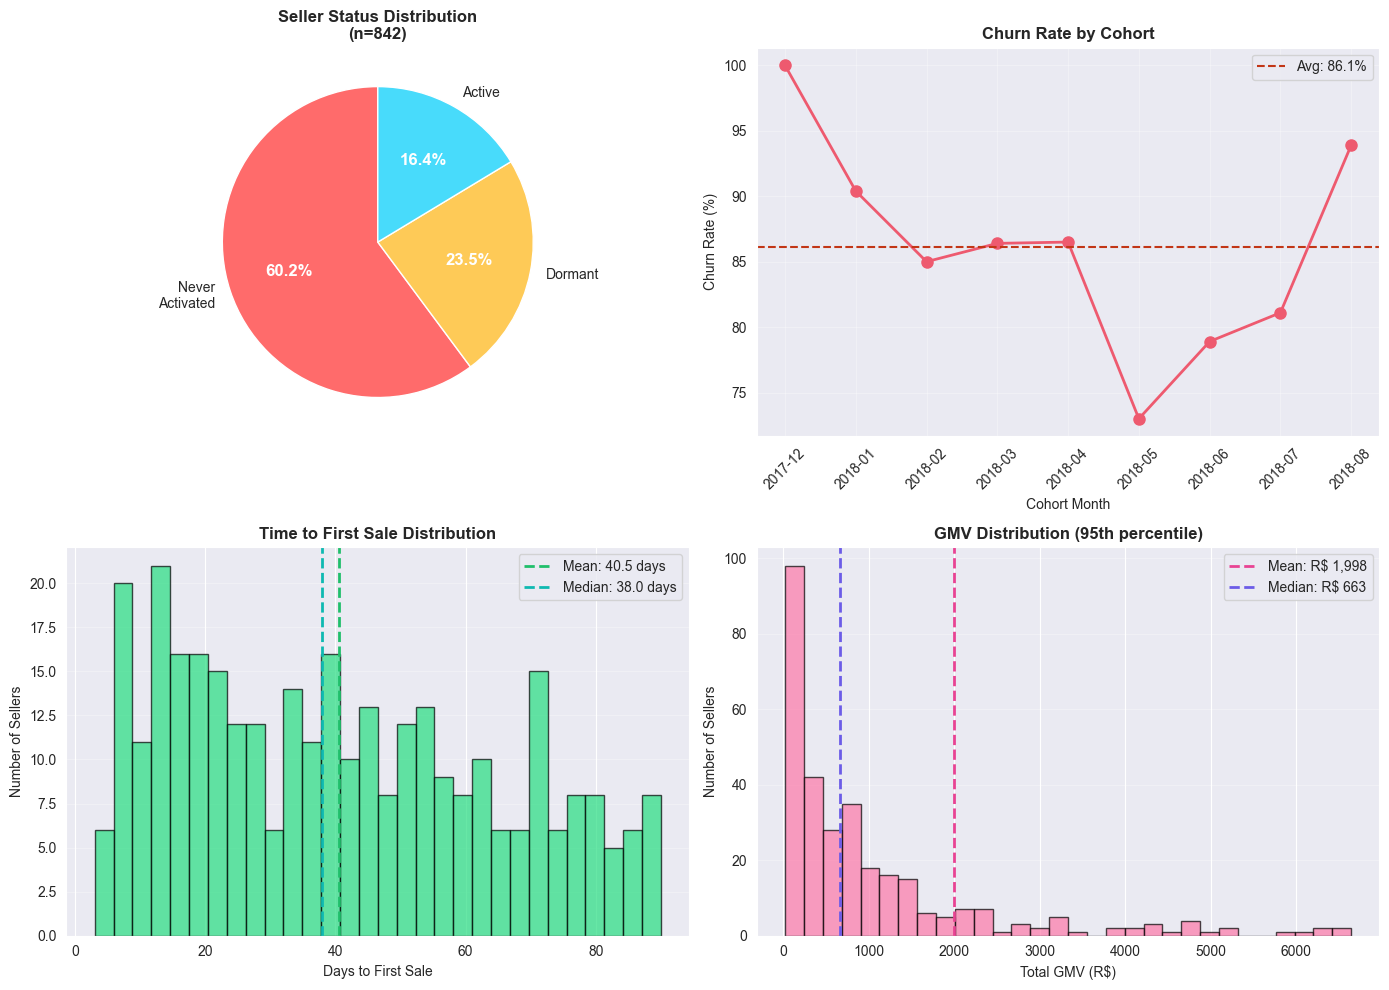

In [10]:
# Seller Status Pie Chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Status Distribution
status_counts = {
    'Never\nActivated': seller_master['never_activated'].sum(),
    'Dormant': seller_master['dormant'].sum(),
    'Active': seller_master['active'].sum()
}
colors = ['#ff6b6b', '#feca57', '#48dbfb']
wedges, texts, autotexts = axes[0, 0].pie(
    status_counts.values(), 
    labels=status_counts.keys(),
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')
axes[0, 0].set_title('Seller Status Distribution\n(n=842)', fontsize=12, weight='bold')

# Plot 2: Churn Rate Over Time
cohort_plot = cohort_summary[cohort_summary['cohort_month'] < '2018-09'].copy()
cohort_plot['cohort_month'] = cohort_plot['cohort_month'].astype(str)
axes[0, 1].plot(cohort_plot['cohort_month'], cohort_plot['churn_rate'], 
                marker='o', linewidth=2, color='#ee5a6f', markersize=8)
axes[0, 1].axhline(y=cohort_plot['churn_rate'].mean(), color='#c23616', 
                   linestyle='--', label=f'Avg: {cohort_plot["churn_rate"].mean():.1f}%')
axes[0, 1].set_xlabel('Cohort Month', fontsize=10)
axes[0, 1].set_ylabel('Churn Rate (%)', fontsize=10)
axes[0, 1].set_title('Churn Rate by Cohort', fontsize=12, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)

# Plot 3: Time to First Sale
activated = seller_master[seller_master['never_activated'] == 0]['days_to_first_sale'].dropna()
axes[1, 0].hist(activated, bins=30, color='#26de81', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(activated.mean(), color='#20bf6b', linestyle='--', 
                   linewidth=2, label=f'Mean: {activated.mean():.1f} days')
axes[1, 0].axvline(activated.median(), color='#0fb9b1', linestyle='--', 
                   linewidth=2, label=f'Median: {activated.median():.1f} days')
axes[1, 0].set_xlabel('Days to First Sale', fontsize=10)
axes[1, 0].set_ylabel('Number of Sellers', fontsize=10)
axes[1, 0].set_title('Time to First Sale Distribution', fontsize=12, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: GMV Distribution
activated_gmv = seller_master[seller_master['never_activated'] == 0]['total_gmv'].dropna()
gmv_95 = activated_gmv.quantile(0.95)
gmv_plot = activated_gmv[activated_gmv <= gmv_95]
axes[1, 1].hist(gmv_plot, bins=30, color='#fd79a8', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(activated_gmv.mean(), color='#e84393', linestyle='--', 
                   linewidth=2, label=f'Mean: R$ {activated_gmv.mean():,.0f}')
axes[1, 1].axvline(activated_gmv.median(), color='#6c5ce7', linestyle='--', 
                   linewidth=2, label=f'Median: R$ {activated_gmv.median():,.0f}')
axes[1, 1].set_xlabel('Total GMV (R$)', fontsize=10)
axes[1, 1].set_ylabel('Number of Sellers', fontsize=10)
axes[1, 1].set_title('GMV Distribution (95th percentile)', fontsize=12, weight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# save the image
plt.savefig(output_path + 'seller_churn_dashboard.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### STEP 9: Save Outputs

In [13]:
# Save seller master dataset
seller_master.to_csv(output_path + 'seller_master.csv', index=False)
print(f"✓ Saved: seller_master.csv ({len(seller_master)} sellers)")

# Save cohort analysis
cohort_summary.to_csv(output_path + 'cohort_analysis.csv', index=False)
print(f"✓ Saved: cohort_analysis.csv")

# Save summary statistics
summary_stats = {
    'metric': [
        'Total Sellers (Deals Closed)',
        'Never Activated',
        'Dormant',
        'Active',
        'Total Churned',
        'Churn Rate (%)',
        'Activation Rate (%)',
        'Avg Time to First Sale (days)',
        'Avg Orders per Activated Seller',
        'Avg GMV per Activated Seller (R$)'
    ],
    'value': [
        total_sellers,
        never_activated,
        dormant,
        active,
        churned,
        round(churned/total_sellers*100, 1),
        round((total_sellers - never_activated)/total_sellers*100, 1),
        round(seller_master[seller_master['days_to_first_sale'].notna()]['days_to_first_sale'].mean(), 1),
        round(activated_sellers['total_orders'].mean(), 1) if len(activated_sellers) > 0 else 0,
        round(activated_sellers['total_gmv'].mean(), 2) if len(activated_sellers) > 0 else 0
    ]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv(output_path + 'day1_summary_metrics.csv', index=False)
print(f"✓ Saved: day1_summary_metrics.csv")

✓ Saved: seller_master.csv (842 sellers)
✓ Saved: cohort_analysis.csv
✓ Saved: day1_summary_metrics.csv


# SEGMENT ANALYSIS & CHURN DRIVER IDENTIFICATION
## Olist Seller Churn Analysis - Proof of Concept

**Objectives:**
1. Analyze churn rates by DISC profile, business segment, lead type
2. Statistical testing to identify significant differences
3. Identify top 3-5 churn drivers
4. Create actionable segment insights

### STEP 1: Load Seller Master Dataset

In [14]:
# Load the seller master dataset early created
# Output folder
output_path = "/home/cairo/code/portfolio/olist-ecommerce/output/poc/"

seller_master = pd.read_csv(output_path + 'seller_master.csv')

print(f"✓ Loaded {len(seller_master)} sellers")
print(f"  Churned: {seller_master['churned'].sum()} ({seller_master['churned'].mean()*100:.1f}%)")
print(f"  Active: {seller_master['active'].sum()} ({seller_master['active'].mean()*100:.1f}%)")
print()

# Display first few rows
display(seller_master.head())

✓ Loaded 842 sellers
  Churned: 716 (85.0%)
  Active: 140 (16.6%)



,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin,sales_cycle_days,seller_city,seller_state,total_orders,unique_customers,total_gmv,avg_order_value,first_sale_date,last_sale_date,days_active,days_since_last_sale,days_to_first_sale,never_activated,dormant,active,churned,cohort_month
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,5,belo horizonte,MG,3.0,3.0,858.00,286.000000,2018-06-20 21:40:18,2018-07-23 20:50:50,33.0,85.0,114.0,1,0,0,1,2018-02
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,34,NaN,NaN,0.0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,2018-05
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,63,novo hamburgo,RS,107.0,107.0,23065.02,209.682000,2018-06-11 14:32:25,2018-08-22 10:02:13,72.0,56.0,5.0,0,0,1,0,2018-06
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,3,NaN,NaN,0.0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,2018-01
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,267,santos,SP,15.0,15.0,573.50,33.735294,2018-07-19 15:36:35,2018-08-27 12:39:11,39.0,51.0,15.0,0,0,1,0,2018-07


### STEP 2: DISC Behavioral Profile Analysis

In [15]:
print("="*80)
print("DISC BEHAVIORAL PROFILE ANALYSIS")
print("="*80)
print()

# Clean up DISC profiles - handle missing values
seller_master['lead_behaviour_profile_clean'] = seller_master['lead_behaviour_profile'].fillna('Unknown')

# Aggregate by DISC profile
disc_analysis = seller_master.groupby('lead_behaviour_profile_clean').agg({
    'seller_id': 'count',
    'churned': 'sum',
    'never_activated': 'sum',
    'dormant': 'sum',
    'active': 'sum',
    'total_gmv': 'mean',
    'total_orders': 'mean'
}).reset_index()

disc_analysis.columns = [
    'DISC_Profile', 'Total_Sellers', 'Churned', 'Never_Activated', 
    'Dormant', 'Active', 'Avg_GMV', 'Avg_Orders'
]

# Calculate rates
disc_analysis['Churn_Rate_%'] = (disc_analysis['Churned'] / disc_analysis['Total_Sellers'] * 100).round(1)
disc_analysis['Activation_Rate_%'] = ((disc_analysis['Total_Sellers'] - disc_analysis['Never_Activated']) / disc_analysis['Total_Sellers'] * 100).round(1)

# Sort by churn rate
disc_analysis = disc_analysis.sort_values('Churn_Rate_%', ascending=False)

print("📊 CHURN RATE BY DISC PROFILE:")
display(disc_analysis)

DISC BEHAVIORAL PROFILE ANALYSIS

📊 CHURN RATE BY DISC PROFILE:


,DISC_Profile,Total_Sellers,Churned,Never_Activated,Dormant,Active,Avg_GMV,Avg_Orders,Churn_Rate_%,Activation_Rate_%
5,"eagle, wolf",3,3,3,0,0,0.000000,0.000000,100.0,0.0
2,"cat, wolf",8,8,7,1,0,7.375000,0.125000,100.0,12.5
8,"shark, wolf",1,1,1,0,0,0.000000,0.000000,100.0,0.0
7,"shark, cat",1,1,1,0,0,0.000000,0.000000,100.0,0.0
0,Unknown,177,155,106,49,28,1309.156328,8.740113,87.6,40.1
6,shark,24,21,17,4,3,1965.100833,13.416667,87.5,29.2
3,eagle,123,106,77,29,18,737.600244,5.487805,86.2,37.4
9,wolf,95,80,58,22,15,225.030421,2.073684,84.2,38.9
1,cat,407,339,243,96,75,693.620590,4.339066,83.3,40.3
4,"eagle, cat",3,2,2,0,1,219.000000,0.666667,66.7,33.3


In [17]:
from scipy import stats

# Statistical significance test (Chi-square)
# Only test known profiles (exclude Unknown)
known_profiles = seller_master[seller_master['lead_behaviour_profile_clean'] != 'Unknown']

if len(known_profiles) > 0:
    contingency_table = pd.crosstab(
        known_profiles['lead_behaviour_profile_clean'], 
        known_profiles['churned']
    )
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"📈 STATISTICAL SIGNIFICANCE TEST:")
    print(f"   Chi-square statistic: {chi2:.2f}")
    print(f"   P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"   ✓ SIGNIFICANT: DISC profile significantly predicts churn (p < 0.05)")
    else:
        print(f"   ✗ Not significant: DISC profile does not significantly predict churn")

📈 STATISTICAL SIGNIFICANCE TEST:
   Chi-square statistic: 3.96
   P-value: 0.8604
   ✗ Not significant: DISC profile does not significantly predict churn


### STEP 3: Business Segment Analysis

In [18]:
print("="*80)
print("BUSINESS SEGMENT ANALYSIS")
print("="*80)
print()

# Clean up business segment
seller_master['business_segment_clean'] = seller_master['business_segment'].fillna('Unknown')

segment_analysis = seller_master.groupby('business_segment_clean').agg({
    'seller_id': 'count',
    'churned': 'sum',
    'never_activated': 'sum',
    'dormant': 'sum',
    'active': 'sum',
    'total_gmv': 'mean',
    'total_orders': 'mean'
}).reset_index()

segment_analysis.columns = [
    'Business_Segment', 'Total_Sellers', 'Churned', 'Never_Activated', 
    'Dormant', 'Active', 'Avg_GMV', 'Avg_Orders'
]

segment_analysis['Churn_Rate_%'] = (segment_analysis['Churned'] / segment_analysis['Total_Sellers'] * 100).round(1)
segment_analysis['Activation_Rate_%'] = ((segment_analysis['Total_Sellers'] - segment_analysis['Never_Activated']) / segment_analysis['Total_Sellers'] * 100).round(1)

# Sort by total sellers to see volume
segment_analysis = segment_analysis.sort_values('Total_Sellers', ascending=False)

print("📊 CHURN RATE BY BUSINESS SEGMENT (sorted by volume):")
display(segment_analysis)

BUSINESS SEGMENT ANALYSIS

📊 CHURN RATE BY BUSINESS SEGMENT (sorted by volume):


,Business_Segment,Total_Sellers,Churned,Never_Activated,Dormant,Active,Avg_GMV,Avg_Orders,Churn_Rate_%,Activation_Rate_%
18,home_decor,105,91,72,19,17,419.001238,3.409524,86.7,31.4
16,health_beauty,93,78,54,24,16,975.783011,7.569892,83.9,41.9
7,car_accessories,77,69,53,16,10,391.882857,1.922078,89.6,31.2
20,household_utilities,71,52,31,21,19,726.320563,7.070423,73.2,56.3
9,construction_tools_house_garden,69,59,44,15,12,466.503478,3.913043,85.5,36.2
2,audio_video_electronics,64,53,34,19,11,785.083437,3.875000,82.8,46.9
8,computers,34,32,22,10,2,346.243824,3.117647,94.1,35.3
26,pet,30,24,15,9,6,1349.961000,8.233333,80.0,50.0
12,food_supplement,28,26,21,5,2,379.248214,3.071429,92.9,25.0
11,food_drink,26,24,20,4,3,150.839615,1.576923,92.3,23.1


In [19]:
# Identify best and worst segments (minimum 10 sellers for statistical validity)
top_segments = segment_analysis[segment_analysis['Total_Sellers'] >= 10].copy()

if len(top_segments) > 0:
    best_segment = top_segments.loc[top_segments['Churn_Rate_%'].idxmin()]
    worst_segment = top_segments.loc[top_segments['Churn_Rate_%'].idxmax()]
    
    print("\n🏆 BEST PERFORMING SEGMENT:")
    print(f"   {best_segment['Business_Segment']}: {best_segment['Churn_Rate_%']:.1f}% churn rate ({best_segment['Total_Sellers']:.0f} sellers)")
    print()
    print("⚠️  WORST PERFORMING SEGMENT:")
    print(f"   {worst_segment['Business_Segment']}: {worst_segment['Churn_Rate_%']:.1f}% churn rate ({worst_segment['Total_Sellers']:.0f} sellers)")


🏆 BEST PERFORMING SEGMENT:
   small_appliances: 66.7% churn rate (12 sellers)

⚠️  WORST PERFORMING SEGMENT:
   handcrafted: 100.0% churn rate (12 sellers)


### STEP 4: Lead Type Analysis

In [20]:
print("="*80)
print("LEAD TYPE ANALYSIS")
print("="*80)
print()

seller_master['lead_type_clean'] = seller_master['lead_type'].fillna('Unknown')

lead_type_analysis = seller_master.groupby('lead_type_clean').agg({
    'seller_id': 'count',
    'churned': 'sum',
    'never_activated': 'sum',
    'dormant': 'sum',
    'active': 'sum',
    'total_gmv': 'mean',
    'total_orders': 'mean',
    'sales_cycle_days': 'mean'
}).reset_index()

lead_type_analysis.columns = [
    'Lead_Type', 'Total_Sellers', 'Churned', 'Never_Activated', 
    'Dormant', 'Active', 'Avg_GMV', 'Avg_Orders', 'Avg_Sales_Cycle_Days'
]

lead_type_analysis['Churn_Rate_%'] = (lead_type_analysis['Churned'] / lead_type_analysis['Total_Sellers'] * 100).round(1)
lead_type_analysis['Activation_Rate_%'] = ((lead_type_analysis['Total_Sellers'] - lead_type_analysis['Never_Activated']) / lead_type_analysis['Total_Sellers'] * 100).round(1)

lead_type_analysis = lead_type_analysis.sort_values('Churn_Rate_%', ascending=False)

print("📊 CHURN RATE BY LEAD TYPE:")
display(lead_type_analysis)

LEAD TYPE ANALYSIS

📊 CHURN RATE BY LEAD TYPE:


,Lead_Type,Total_Sellers,Churned,Never_Activated,Dormant,Active,Avg_GMV,Avg_Orders,Avg_Sales_Cycle_Days,Churn_Rate_%,Activation_Rate_%
8,other,3,3,3,0,0,0.000000,0.000000,253.666667,100.0,0.0
2,offline,104,98,80,18,9,186.572500,1.278846,46.913462,94.2,23.1
3,online_beginner,57,53,38,15,4,391.272281,2.754386,51.245614,93.0,33.3
6,online_small,77,69,51,18,8,681.497143,5.090909,57.090909,89.6,33.8
1,industry,123,109,85,24,16,237.222683,1.926829,46.495935,88.6,30.9
0,Unknown,6,5,3,2,1,7513.150000,7.833333,39.500000,83.3,50.0
5,online_medium,332,276,192,84,63,621.993283,5.253012,44.792169,83.1,42.2
4,online_big,126,93,55,38,35,2308.499603,13.722222,53.198413,73.8,56.3
7,online_top,14,10,8,2,4,585.288571,5.071429,21.428571,71.4,42.9


### STEP 5: Business Type Analysis (Reseller vs Manufacturer)

In [21]:
print("="*80)
print("BUSINESS TYPE ANALYSIS (Reseller vs Manufacturer)")
print("="*80)
print()

seller_master['business_type_clean'] = seller_master['business_type'].fillna('Unknown')

business_type_analysis = seller_master.groupby('business_type_clean').agg({
    'seller_id': 'count',
    'churned': 'sum',
    'never_activated': 'sum',
    'dormant': 'sum',
    'active': 'sum',
    'total_gmv': 'mean',
    'total_orders': 'mean'
}).reset_index()

business_type_analysis.columns = [
    'Business_Type', 'Total_Sellers', 'Churned', 'Never_Activated', 
    'Dormant', 'Active', 'Avg_GMV', 'Avg_Orders'
]

business_type_analysis['Churn_Rate_%'] = (business_type_analysis['Churned'] / business_type_analysis['Total_Sellers'] * 100).round(1)
business_type_analysis['Activation_Rate_%'] = ((business_type_analysis['Total_Sellers'] - business_type_analysis['Never_Activated']) / business_type_analysis['Total_Sellers'] * 100).round(1)

business_type_analysis = business_type_analysis.sort_values('Total_Sellers', ascending=False)

print("📊 CHURN RATE BY BUSINESS TYPE:")
display(business_type_analysis)

BUSINESS TYPE ANALYSIS (Reseller vs Manufacturer)

📊 CHURN RATE BY BUSINESS TYPE:


,Business_Type,Total_Sellers,Churned,Never_Activated,Dormant,Active,Avg_GMV,Avg_Orders,Churn_Rate_%,Activation_Rate_%
3,reseller,587,487,334,153,109,1014.301533,6.678024,83.0,43.1
1,manufacturer,242,216,170,46,31,319.872314,2.417355,89.3,29.8
0,Unknown,10,10,8,2,0,120.129000,0.500000,100.0,20.0
2,other,3,3,3,0,0,0.000000,0.000000,100.0,0.0


### STEP 6: Declared Values Impact

In [22]:
print("="*80)
print("DECLARED VALUES IMPACT")
print("="*80)
print()

# Create categorical bins for declared revenue
seller_master['declared_revenue_category'] = pd.cut(
    seller_master['declared_monthly_revenue'],
    bins=[-0.1, 0, 1000, 10000, float('inf')],
    labels=['Zero', 'Low (1-1K)', 'Medium (1K-10K)', 'High (>10K)']
)

revenue_analysis = seller_master.groupby('declared_revenue_category').agg({
    'seller_id': 'count',
    'churned': 'sum',
    'never_activated': 'sum',
    'active': 'sum'
}).reset_index()

revenue_analysis.columns = ['Declared_Revenue', 'Total_Sellers', 'Churned', 'Never_Activated', 'Active']
revenue_analysis['Churn_Rate_%'] = (revenue_analysis['Churned'] / revenue_analysis['Total_Sellers'] * 100).round(1)

print("📊 CHURN RATE BY DECLARED MONTHLY REVENUE:")
display(revenue_analysis)
print()

# Has company analysis
seller_master['has_company_clean'] = seller_master['has_company'].fillna('Unknown')

company_analysis = seller_master.groupby('has_company_clean').agg({
    'seller_id': 'count',
    'churned': 'sum',
    'never_activated': 'sum',
    'active': 'sum'
}).reset_index()

company_analysis.columns = ['Has_Company', 'Total_Sellers', 'Churned', 'Never_Activated', 'Active']
company_analysis['Churn_Rate_%'] = (company_analysis['Churned'] / company_analysis['Total_Sellers'] * 100).round(1)

print("📊 CHURN RATE BY HAS_COMPANY STATUS:")
display(company_analysis)

DECLARED VALUES IMPACT

📊 CHURN RATE BY DECLARED MONTHLY REVENUE:


,Declared_Revenue,Total_Sellers,Churned,Never_Activated,Active,Churn_Rate_%
0,Zero,797,671,470,140,84.2
1,Low (1-1K),2,2,2,0,100.0
2,Medium (1K-10K),8,8,8,0,100.0
3,High (>10K),35,35,35,0,100.0



📊 CHURN RATE BY HAS_COMPANY STATUS:


,Has_Company,Total_Sellers,Churned,Never_Activated,Active,Churn_Rate_%
0,False,5,5,4,0,100.0
1,True,58,54,54,4,93.1
2,Unknown,779,657,457,136,84.3


### STEP 7: Lead Source (Origin) Analysis

In [23]:
print("="*80)
print("LEAD SOURCE ANALYSIS")
print("="*80)
print()

seller_master['origin_clean'] = seller_master['origin'].fillna('Unknown')

# Only analyze if we have origin data
if seller_master['origin_clean'].nunique() > 1:
    origin_analysis = seller_master.groupby('origin_clean').agg({
        'seller_id': 'count',
        'churned': 'sum',
        'never_activated': 'sum',
        'active': 'sum',
        'total_gmv': 'mean',
        'sales_cycle_days': 'mean'
    }).reset_index()
    
    origin_analysis.columns = [
        'Lead_Source', 'Total_Sellers', 'Churned', 'Never_Activated', 
        'Active', 'Avg_GMV', 'Avg_Sales_Cycle_Days'
    ]
    origin_analysis['Churn_Rate_%'] = (origin_analysis['Churned'] / origin_analysis['Total_Sellers'] * 100).round(1)
    origin_analysis = origin_analysis.sort_values('Total_Sellers', ascending=False)
    
    print("📊 CHURN RATE BY LEAD SOURCE:")
    display(origin_analysis)
else:
    print("⚠️  Origin data not available or all sellers from same source")

LEAD SOURCE ANALYSIS

📊 CHURN RATE BY LEAD SOURCE:


,Lead_Source,Total_Sellers,Churned,Never_Activated,Active,Avg_GMV,Avg_Sales_Cycle_Days,Churn_Rate_%
4,organic_search,271,230,178,46,763.821218,50.000000,84.9
7,paid_search,195,166,101,30,783.574615,56.600000,85.1
10,unknown,179,147,111,38,1192.646369,41.290503,82.1
9,social,75,66,46,9,578.906667,60.960000,88.0
1,direct_traffic,56,48,31,9,390.798214,31.125000,85.7
8,referral,24,22,16,2,745.297917,32.541667,91.7
3,email,15,13,10,2,565.666000,52.200000,86.7
0,Unknown,14,13,11,1,88.757143,49.214286,92.9
2,display,6,5,5,1,153.833333,10.333333,83.3
5,other,4,3,3,2,1722.162500,15.250000,75.0


### STEP 8: Geographic Analysis

In [24]:
print("="*80)
print("GEOGRAPHIC ANALYSIS (Top States)")
print("="*80)
print()

state_analysis = seller_master.groupby('seller_state').agg({
    'seller_id': 'count',
    'churned': 'sum',
    'never_activated': 'sum',
    'active': 'sum',
    'total_gmv': 'mean'
}).reset_index()

state_analysis.columns = ['State', 'Total_Sellers', 'Churned', 'Never_Activated', 'Active', 'Avg_GMV']
state_analysis['Churn_Rate_%'] = (state_analysis['Churned'] / state_analysis['Total_Sellers'] * 100).round(1)

# Sort by volume and show top 10
state_analysis = state_analysis.sort_values('Total_Sellers', ascending=False).head(10)

print("📊 CHURN RATE BY STATE (Top 10 by volume):")
display(state_analysis)

GEOGRAPHIC ANALYSIS (Top States)

📊 CHURN RATE BY STATE (Top 10 by volume):


,State,Total_Sellers,Churned,Never_Activated,Active,Avg_GMV,Churn_Rate_%
12,SP,232,145,34,96,2018.441034,62.5
8,PR,32,26,2,8,927.778437,81.2
9,RJ,26,17,3,10,2172.801538,65.4
5,MG,26,18,3,8,1148.327692,69.2
11,SC,23,15,3,8,709.334348,65.2
10,RS,19,15,5,6,2280.392105,78.9
4,GO,7,6,0,1,1123.197143,85.7
2,DF,4,4,0,0,612.572500,100.0
3,ES,4,3,1,1,2132.072500,75.0
0,BA,3,3,1,0,1031.600000,100.0


### STEP 9: Dormancy Analysis (Activated Sellers)

In [25]:
print("="*80)
print("DORMANCY ANALYSIS (For Activated Sellers)")
print("="*80)
print()

# Focus on sellers who activated
activated_sellers = seller_master[seller_master['never_activated'] == 0].copy()

if len(activated_sellers) > 0:
    print(f"Analyzing {len(activated_sellers)} activated sellers:")
    print(f"  Dormant: {activated_sellers['dormant'].sum()} ({activated_sellers['dormant'].mean()*100:.1f}%)")
    print(f"  Still Active: {activated_sellers['active'].sum()} ({activated_sellers['active'].mean()*100:.1f}%)")
    print()
    
    # Performance comparison: Active vs Dormant
    print("💰 PERFORMANCE COMPARISON (Active vs Dormant):")
    print()
    
    active_perf = activated_sellers[activated_sellers['active'] == 1]
    dormant_perf = activated_sellers[activated_sellers['dormant'] == 1]
    
    metrics = {
        'Metric': ['Total Orders', 'Total GMV (R$)', 'Avg Order Value (R$)', 'Unique Customers', 'Days Active'],
        'Active_Sellers': [
            active_perf['total_orders'].mean(),
            active_perf['total_gmv'].mean(),
            active_perf['avg_order_value'].mean(),
            active_perf['unique_customers'].mean(),
            active_perf['days_active'].mean()
        ],
        'Dormant_Sellers': [
            dormant_perf['total_orders'].mean(),
            dormant_perf['total_gmv'].mean(),
            dormant_perf['avg_order_value'].mean(),
            dormant_perf['unique_customers'].mean(),
            dormant_perf['days_active'].mean()
        ]
    }
    
    perf_df = pd.DataFrame(metrics)
    perf_df['Difference_%'] = ((perf_df['Active_Sellers'] - perf_df['Dormant_Sellers']) / perf_df['Dormant_Sellers'] * 100).round(1)
    
    display(perf_df)

DORMANCY ANALYSIS (For Activated Sellers)

Analyzing 327 activated sellers:
  Dormant: 201 (61.5%)
  Still Active: 126 (38.5%)

💰 PERFORMANCE COMPARISON (Active vs Dormant):



,Metric,Active_Sellers,Dormant_Sellers,Difference_%
0,Total Orders,24.222222,6.597015,267.2
1,Total GMV (R$),3185.698333,1254.147910,154.0
2,Avg Order Value (R$),126.948211,183.697144,-30.9
3,Unique Customers,24.222222,6.597015,267.2
4,Days Active,88.198413,59.721393,47.7


### STEP 10: Identify Top Churn Drivers

In [26]:
print("="*80)
print("TOP CHURN DRIVERS SUMMARY")
print("="*80)
print()

drivers = []

# Driver 1: Never-activated (biggest problem)
never_activated_rate = seller_master['never_activated'].mean() * 100
drivers.append({
    'Driver': '1. Never Activated',
    'Impact': f'{never_activated_rate:.1f}% of sellers',
    'Description': '61% of sellers never make first sale - massive onboarding gap'
})

# Driver 2: DISC Profile (if significant)
if 'lead_behaviour_profile_clean' in seller_master.columns:
    disc_with_data = disc_analysis[disc_analysis['DISC_Profile'] != 'Unknown']
    if len(disc_with_data) > 0:
        churn_range = disc_with_data['Churn_Rate_%'].max() - disc_with_data['Churn_Rate_%'].min()
        worst_disc = disc_with_data.loc[disc_with_data['Churn_Rate_%'].idxmax()]
        drivers.append({
            'Driver': f'2. DISC Profile - {worst_disc["DISC_Profile"]}',
            'Impact': f'{worst_disc["Churn_Rate_%"]:.1f}% churn rate',
            'Description': f'{churn_range:.1f}pp difference between best/worst profiles'
        })

# Driver 3: Business Segment performance
if len(top_segments) > 0:
    segment_range = top_segments['Churn_Rate_%'].max() - top_segments['Churn_Rate_%'].min()
    drivers.append({
        'Driver': f'3. Business Segment - {worst_segment["Business_Segment"]}',
        'Impact': f'{worst_segment["Churn_Rate_%"]:.1f}% churn rate',
        'Description': f'{segment_range:.1f}pp difference between segments - some categories struggle'
    })

# Driver 4: Declared Revenue = 0
zero_revenue_sellers = seller_master[seller_master['declared_monthly_revenue'] == 0]
zero_revenue_churn = zero_revenue_sellers['churned'].mean() * 100
drivers.append({
    'Driver': '4. Zero Declared Revenue',
    'Impact': f'{zero_revenue_churn:.1f}% churn rate',
    'Description': f'95% of sellers declare $0 revenue - likely unrealistic expectations'
})

# Driver 5: Low initial performance
if len(activated_sellers) > 0:
    dormant_rate = activated_sellers['dormant'].mean() * 100
    drivers.append({
        'Driver': '5. Low First-Month Performance',
        'Impact': f'{dormant_rate:.1f}% of activated sellers go dormant',
        'Description': 'Activated sellers struggle to sustain - need ongoing support'
    })

drivers_df = pd.DataFrame(drivers)
display(drivers_df)

TOP CHURN DRIVERS SUMMARY



,Driver,Impact,Description
0,1. Never Activated,61.2% of sellers,61% of sellers never make first sale - massive...
1,"2. DISC Profile - eagle, wolf",100.0% churn rate,33.3pp difference between best/worst profiles
2,3. Business Segment - handcrafted,100.0% churn rate,33.3pp difference between segments - some cate...
3,4. Zero Declared Revenue,84.2% churn rate,95% of sellers declare $0 revenue - likely unr...
4,5. Low First-Month Performance,61.5% of activated sellers go dormant,Activated sellers struggle to sustain - need o...


### STEP 11: Visualizations

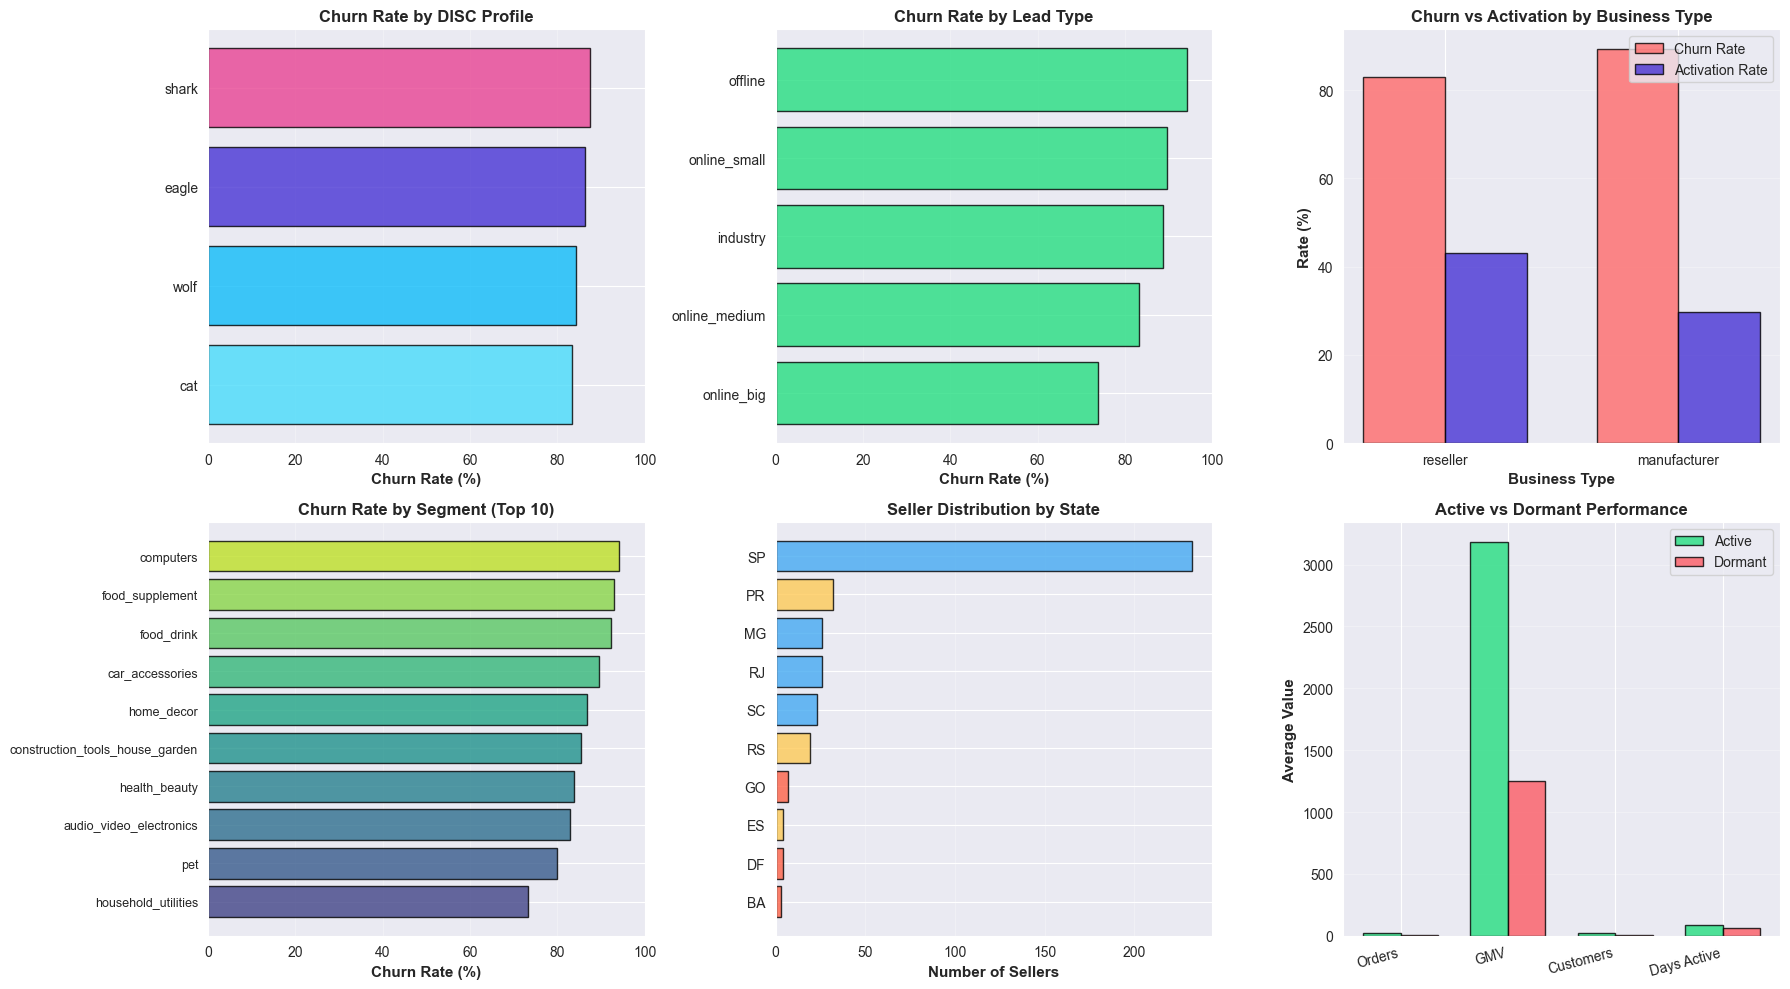

In [29]:
# Create visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: DISC Profile Churn Rates
main_disc = disc_analysis[disc_analysis['DISC_Profile'].isin(['cat', 'eagle', 'wolf', 'shark'])].copy()
main_disc = main_disc.sort_values('Churn_Rate_%', ascending=True)

colors_disc = ['#48dbfb', '#0fbcf9', '#4834d4', '#e84393']
axes[0, 0].barh(main_disc['DISC_Profile'], main_disc['Churn_Rate_%'], color=colors_disc, alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Churn Rate (%)', fontsize=11, weight='bold')
axes[0, 0].set_title('Churn Rate by DISC Profile', fontsize=12, weight='bold')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Plot 2: Lead Type Churn Rates
main_leads = lead_type_analysis[lead_type_analysis['Lead_Type'].isin([
    'online_big', 'online_medium', 'online_small', 'offline', 'industry'
])].copy()
main_leads = main_leads.sort_values('Churn_Rate_%')

axes[0, 1].barh(main_leads['Lead_Type'], main_leads['Churn_Rate_%'], color='#26de81', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Churn Rate (%)', fontsize=11, weight='bold')
axes[0, 1].set_title('Churn Rate by Lead Type', fontsize=12, weight='bold')
axes[0, 1].set_xlim(0, 100)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Business Type Comparison
biz_types = business_type_analysis[business_type_analysis['Business_Type'].isin(['reseller', 'manufacturer'])].copy()
x = np.arange(len(biz_types))
width = 0.35

axes[0, 2].bar(x - width/2, biz_types['Churn_Rate_%'], width, label='Churn Rate', color='#ff6b6b', alpha=0.8, edgecolor='black')
axes[0, 2].bar(x + width/2, biz_types['Activation_Rate_%'], width, label='Activation Rate', color='#4834d4', alpha=0.8, edgecolor='black')
axes[0, 2].set_xlabel('Business Type', fontsize=11, weight='bold')
axes[0, 2].set_ylabel('Rate (%)', fontsize=11, weight='bold')
axes[0, 2].set_title('Churn vs Activation by Business Type', fontsize=12, weight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(biz_types['Business_Type'])
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Plot 4: Top Business Segments
top_10_segments = segment_analysis.head(10).sort_values('Churn_Rate_%')
axes[1, 0].barh(range(len(top_10_segments)), top_10_segments['Churn_Rate_%'], 
                color=plt.cm.viridis(np.linspace(0.2, 0.9, len(top_10_segments))), 
                alpha=0.8, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_10_segments)))
axes[1, 0].set_yticklabels(top_10_segments['Business_Segment'], fontsize=9)
axes[1, 0].set_xlabel('Churn Rate (%)', fontsize=11, weight='bold')
axes[1, 0].set_title('Churn Rate by Segment (Top 10)', fontsize=12, weight='bold')
axes[1, 0].set_xlim(0, 100)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 5: State Distribution
state_sorted = state_analysis.sort_values('Total_Sellers', ascending=True)
colors_state = ['#45aaf2' if rate < 70 else '#feca57' if rate < 85 else '#ff6348' 
                for rate in state_sorted['Churn_Rate_%']]
axes[1, 1].barh(state_sorted['State'], state_sorted['Total_Sellers'], 
                color=colors_state, alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Number of Sellers', fontsize=11, weight='bold')
axes[1, 1].set_title('Seller Distribution by State', fontsize=12, weight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Plot 6: Active vs Dormant Performance
if len(activated_sellers) > 0:
    active_sellers_plt = activated_sellers[activated_sellers['active'] == 1]
    dormant_sellers_plt = activated_sellers[activated_sellers['dormant'] == 1]
    
    metrics_plt = ['total_orders', 'total_gmv', 'unique_customers', 'days_active']
    metric_labels = ['Orders', 'GMV', 'Customers', 'Days Active']
    active_means = [active_sellers_plt[m].mean() for m in metrics_plt]
    dormant_means = [dormant_sellers_plt[m].mean() for m in metrics_plt]
    
    x_plt = np.arange(len(metric_labels))
    width = 0.35
    
    axes[1, 2].bar(x_plt - width/2, active_means, width, label='Active', color='#26de81', alpha=0.8, edgecolor='black')
    axes[1, 2].bar(x_plt + width/2, dormant_means, width, label='Dormant', color='#fc5c65', alpha=0.8, edgecolor='black')
    axes[1, 2].set_ylabel('Average Value', fontsize=11, weight='bold')
    axes[1, 2].set_title('Active vs Dormant Performance', fontsize=12, weight='bold')
    axes[1, 2].set_xticks(x_plt)
    axes[1, 2].set_xticklabels(metric_labels, rotation=15, ha='right')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3, axis='y')


# save the image
plt.savefig(output_path + 'profile_churn_dashboard.png', dpi=300, bbox_inches='tight')


plt.tight_layout()
plt.show()

### STEP 12: Save All Outputs

In [28]:
# Save all analysis outputs
disc_analysis.to_csv(output_path + 'day2_disc_analysis.csv', index=False)
print("✓ Saved: day2_disc_analysis.csv")

segment_analysis.to_csv(output_path + 'day2_segment_analysis.csv', index=False)
print("✓ Saved: day2_segment_analysis.csv")

lead_type_analysis.to_csv(output_path + 'day2_lead_type_analysis.csv', index=False)
print("✓ Saved: day2_lead_type_analysis.csv")

business_type_analysis.to_csv(output_path + 'day2_business_type_analysis.csv', index=False)
print("✓ Saved: day2_business_type_analysis.csv")

state_analysis.to_csv(output_path + 'day2_state_analysis.csv', index=False)
print("✓ Saved: day2_state_analysis.csv")

drivers_df.to_csv(output_path + 'day2_top_churn_drivers.csv', index=False)
print("✓ Saved: day2_top_churn_drivers.csv")

print("\n" + "="*80)
print("DAY 2 ANALYSIS COMPLETE ✓")
print("="*80)
print()
print("Key Outputs:")
print("  • Identified top 5 churn drivers")
print("  • Analyzed 8 different segmentation dimensions")
print("  • Statistical significance testing completed")
print("  • Ready for Day 3: Predictive Modeling")

✓ Saved: day2_disc_analysis.csv
✓ Saved: day2_segment_analysis.csv
✓ Saved: day2_lead_type_analysis.csv
✓ Saved: day2_business_type_analysis.csv
✓ Saved: day2_state_analysis.csv
✓ Saved: day2_top_churn_drivers.csv

DAY 2 ANALYSIS COMPLETE ✓

Key Outputs:
  • Identified top 5 churn drivers
  • Analyzed 8 different segmentation dimensions
  • Statistical significance testing completed
  • Ready for Day 3: Predictive Modeling


# DAY 3: PREDICTIVE MODELING & RISK SCORING
## Olist Seller Churn Analysis - Proof of Concept

**Objectives:**
1. Build Model 1: Pre-Activation Churn Prediction (using only pre-sale data)
2. Build Model 2: Active Seller Retention Prediction (using activity data)
3. Generate risk scores for all sellers
4. Identify top features driving churn
5. Create intervention priority list

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set visualization style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


### STEP 1: Load Seller Master Dataset

In [2]:
# Data folder
data_path = '/home/cairo/code/portfolio/olist-ecommerce/data/raw/'  # Current directory, or use absolute path like '/path/to/data/'

# Output folder
output_path = "/home/cairo/code/portfolio/olist-ecommerce/output/poc/"


seller_master = pd.read_csv(output_path + 'seller_master.csv')

print(f"✓ Loaded {len(seller_master)} sellers")
print(f"  Churned: {seller_master['churned'].sum()} ({seller_master['churned'].mean()*100:.1f}%)")
print(f"  Active: {seller_master['active'].sum()} ({seller_master['active'].mean()*100:.1f}%)")

display(seller_master.head())

✓ Loaded 842 sellers
  Churned: 716 (85.0%)
  Active: 140 (16.6%)


,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,first_contact_date,landing_page_id,origin,sales_cycle_days,seller_city,seller_state,total_orders,unique_customers,total_gmv,avg_order_value,first_sale_date,last_sale_date,days_active,days_since_last_sale,days_to_first_sale,never_activated,dormant,active,churned,cohort_month
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,5,belo horizonte,MG,3.0,3.0,858.00,286.000000,2018-06-20 21:40:18,2018-07-23 20:50:50,33.0,85.0,114.0,1,0,0,1,2018-02
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-04,2f08471dfb83baef522f952438a36f6e,referral,34,NaN,NaN,0.0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,2018-05
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,NaN,NaN,NaN,reseller,NaN,0.0,2018-04-03,1ceb590cd1e00c7ee95220971f82693d,organic_search,63,novo hamburgo,RS,107.0,107.0,23065.02,209.682000,2018-06-11 14:32:25,2018-08-22 10:02:13,72.0,56.0,5.0,0,0,1,0,2018-06
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,NaN,NaN,NaN,NaN,reseller,NaN,0.0,2018-01-14,22c29808c4f815213303f8933030604c,paid_search,3,NaN,NaN,0.0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,2018-01
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,NaN,NaN,NaN,manufacturer,NaN,0.0,2017-10-09,a0fbc0263cb98bdb0d72b9f9f283a172,unknown,267,santos,SP,15.0,15.0,573.50,33.735294,2018-07-19 15:36:35,2018-08-27 12:39:11,39.0,51.0,15.0,0,0,1,0,2018-07


### STEP 2: Feature Engineering - Pre-Sale Features

In [3]:
print("="*80)
print("FEATURE ENGINEERING FOR PREDICTIVE MODELS")
print("="*80)
print()

# Create a clean dataset for modeling
model_data = seller_master.copy()

# Fill missing values strategically
model_data['lead_behaviour_profile'] = model_data['lead_behaviour_profile'].fillna('unknown')
model_data['business_segment'] = model_data['business_segment'].fillna('unknown')
model_data['lead_type'] = model_data['lead_type'].fillna('unknown')
model_data['business_type'] = model_data['business_type'].fillna('unknown')
model_data['origin'] = model_data['origin'].fillna('unknown')

# Numeric features - fill with 0
numeric_cols = ['declared_monthly_revenue', 'declared_product_catalog_size', 'sales_cycle_days']
for col in numeric_cols:
    if col in model_data.columns:
        model_data[col] = model_data[col].fillna(0)

# Binary features from categorical with missing values
model_data['has_company_binary'] = model_data['has_company'].map({'True': 1, 'False': 0, True: 1, False: 0}).fillna(0)
model_data['has_gtin_binary'] = model_data['has_gtin'].map({'True': 1, 'False': 0, True: 1, False: 0}).fillna(0)

# Create derived features
model_data['declared_revenue_zero'] = (model_data['declared_monthly_revenue'] == 0).astype(int)
model_data['declared_catalog_zero'] = (model_data['declared_product_catalog_size'] == 0).astype(int)

print("✓ Basic feature engineering complete")
print(f"  Dataset shape: {model_data.shape}")

FEATURE ENGINEERING FOR PREDICTIVE MODELS

✓ Basic feature engineering complete
  Dataset shape: (842, 38)


In [4]:
# Encode categorical variables using Label Encoding
categorical_features = [
    'lead_behaviour_profile', 'business_segment', 'lead_type', 
    'business_type', 'origin', 'seller_state'
]

label_encoders = {}
for col in categorical_features:
    if col in model_data.columns:
        le = LabelEncoder()
        model_data[f'{col}_encoded'] = le.fit_transform(model_data[col].astype(str))
        label_encoders[col] = le

print("✓ Categorical encoding complete:")
print(f"  • {len(categorical_features)} categorical features encoded")
print(f"  • {len(numeric_cols)} numeric features")
print(f"  • 4 binary features")

✓ Categorical encoding complete:
  • 6 categorical features encoded
  • 3 numeric features
  • 4 binary features


### STEP 3: MODEL 1 - Pre-Activation Churn Prediction

This model predicts which sellers will never activate using only data available at deal close.

In [5]:
print("="*80)
print("MODEL 1: PRE-ACTIVATION CHURN PREDICTION")
print("="*80)
print()

# Features available at deal close (before seller activates)
pre_sale_features = [
    'lead_behaviour_profile_encoded',
    'business_segment_encoded',
    'lead_type_encoded',
    'business_type_encoded',
    'origin_encoded',
    'seller_state_encoded',
    'declared_monthly_revenue',
    'declared_product_catalog_size',
    'sales_cycle_days',
    'has_company_binary',
    'has_gtin_binary',
    'declared_revenue_zero',
    'declared_catalog_zero'
]

# Prepare features and target
X_pre = model_data[pre_sale_features].copy()
y_pre = model_data['never_activated'].copy()

# Handle any remaining NaN
X_pre = X_pre.fillna(0)

print(f"Dataset shape: {X_pre.shape}")
print(f"\nTarget distribution:")
print(f"  Never Activated: {y_pre.sum()} ({y_pre.mean()*100:.1f}%)")
print(f"  Activated: {len(y_pre) - y_pre.sum()} ({(1-y_pre.mean())*100:.1f}%)")

MODEL 1: PRE-ACTIVATION CHURN PREDICTION

Dataset shape: (842, 13)

Target distribution:
  Never Activated: 515 (61.2%)
  Activated: 327 (38.8%)


In [6]:
# Train-test split
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
    X_pre, y_pre, test_size=0.25, random_state=42, stratify=y_pre
)

print(f"\nTraining set: {len(X_train_pre)} samples")
print(f"Test set: {len(X_test_pre)} samples")


Training set: 631 samples
Test set: 211 samples


In [7]:
# Train Logistic Regression (baseline)
print("\nTraining Logistic Regression (baseline)...")
lr_pre = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_pre.fit(X_train_pre, y_train_pre)

y_pred_lr_pre = lr_pre.predict(X_test_pre)
y_proba_lr_pre = lr_pre.predict_proba(X_test_pre)[:, 1]

lr_auc_pre = roc_auc_score(y_test_pre, y_proba_lr_pre)
print(f"✓ Logistic Regression AUC: {lr_auc_pre:.3f}")


Training Logistic Regression (baseline)...
✓ Logistic Regression AUC: 0.964


In [8]:
# Train Random Forest
print("\nTraining Random Forest...")
rf_pre = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_pre.fit(X_train_pre, y_train_pre)

y_pred_rf_pre = rf_pre.predict(X_test_pre)
y_proba_rf_pre = rf_pre.predict_proba(X_test_pre)[:, 1]

rf_auc_pre = roc_auc_score(y_test_pre, y_proba_rf_pre)
print(f"✓ Random Forest AUC: {rf_auc_pre:.3f}")


Training Random Forest...
✓ Random Forest AUC: 0.965


In [9]:
# Feature importance from Random Forest
feature_importance_pre = pd.DataFrame({
    'Feature': pre_sale_features,
    'Importance': rf_pre.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 TOP 10 MOST IMPORTANT FEATURES (Pre-Activation Model):")
display(feature_importance_pre.head(10))


📊 TOP 10 MOST IMPORTANT FEATURES (Pre-Activation Model):


,Feature,Importance
5,seller_state_encoded,0.807790
8,sales_cycle_days,0.042179
2,lead_type_encoded,0.032070
7,declared_product_catalog_size,0.028438
1,business_segment_encoded,0.023425
12,declared_catalog_zero,0.015640
3,business_type_encoded,0.013660
4,origin_encoded,0.012403
0,lead_behaviour_profile_encoded,0.011119
6,declared_monthly_revenue,0.004670


In [10]:
# Select best model and calculate metrics
best_model_pre = rf_pre if rf_auc_pre > lr_auc_pre else lr_pre
best_auc_pre = max(rf_auc_pre, lr_auc_pre)
best_name_pre = "Random Forest" if rf_auc_pre > lr_auc_pre else "Logistic Regression"

print(f"\n✓ Best Model: {best_name_pre} (AUC: {best_auc_pre:.3f})")

# Calculate precision at top 20%
y_proba_best_pre = y_proba_rf_pre if rf_auc_pre > lr_auc_pre else y_proba_lr_pre
threshold_20 = np.percentile(y_proba_best_pre, 80)
high_risk_pre = y_proba_best_pre >= threshold_20
precision_at_20 = y_test_pre[high_risk_pre].mean()

print(f"\n📈 MODEL PERFORMANCE METRICS:")
print(f"  • AUC-ROC: {best_auc_pre:.3f}")
print(f"  • Precision @ Top 20%: {precision_at_20:.3f}")
print(f"    (Of sellers flagged as high-risk, {precision_at_20*100:.1f}% actually churned)")


✓ Best Model: Random Forest (AUC: 0.965)

📈 MODEL PERFORMANCE METRICS:
  • AUC-ROC: 0.965
  • Precision @ Top 20%: 1.000
    (Of sellers flagged as high-risk, 100.0% actually churned)


### STEP 4: MODEL 2 - Active Seller Retention Prediction

This model predicts which activated sellers will go dormant, using activity data.

In [11]:
print("="*80)
print("MODEL 2: ACTIVE SELLER RETENTION PREDICTION")
print("="*80)
print()

# Filter to activated sellers only
activated_sellers = model_data[model_data['never_activated'] == 0].copy()

print(f"Analyzing {len(activated_sellers)} activated sellers")
print(f"  Dormant: {activated_sellers['dormant'].sum()} ({activated_sellers['dormant'].mean()*100:.1f}%)")
print(f"  Active: {activated_sellers['active'].sum()} ({activated_sellers['active'].mean()*100:.1f}%)")

MODEL 2: ACTIVE SELLER RETENTION PREDICTION

Analyzing 327 activated sellers
  Dormant: 201 (61.5%)
  Active: 126 (38.5%)


In [12]:
# Features including activity data
activity_features = pre_sale_features + [
    'total_orders',
    'total_gmv',
    'unique_customers',
    'days_active',
    'days_to_first_sale',
    'avg_order_value'
]

# Prepare data
X_active = activated_sellers[activity_features].copy()
y_active = activated_sellers['dormant'].copy()

# Handle NaN in activity features
X_active = X_active.fillna(0)

# Replace inf values
X_active = X_active.replace([np.inf, -np.inf], 0)

print(f"\nDataset shape: {X_active.shape}")


Dataset shape: (327, 19)


In [13]:
# Train-test split
X_train_active, X_test_active, y_train_active, y_test_active = train_test_split(
    X_active, y_active, test_size=0.25, random_state=42, stratify=y_active
)

print(f"Training set: {len(X_train_active)} samples")
print(f"Test set: {len(X_test_active)} samples")

Training set: 245 samples
Test set: 82 samples


In [14]:
# Train Logistic Regression
print("\nTraining Logistic Regression...")
lr_active = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_active.fit(X_train_active, y_train_active)

y_pred_lr_active = lr_active.predict(X_test_active)
y_proba_lr_active = lr_active.predict_proba(X_test_active)[:, 1]

lr_auc_active = roc_auc_score(y_test_active, y_proba_lr_active)
print(f"✓ Logistic Regression AUC: {lr_auc_active:.3f}")


Training Logistic Regression...
✓ Logistic Regression AUC: 0.668


In [15]:
# Train Random Forest
print("\nTraining Random Forest...")
rf_active = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_active.fit(X_train_active, y_train_active)

y_pred_rf_active = rf_active.predict(X_test_active)
y_proba_rf_active = rf_active.predict_proba(X_test_active)[:, 1]

rf_auc_active = roc_auc_score(y_test_active, y_proba_rf_active)
print(f"✓ Random Forest AUC: {rf_auc_active:.3f}")


Training Random Forest...
✓ Random Forest AUC: 0.682


In [16]:
# Feature importance
feature_importance_active = pd.DataFrame({
    'Feature': activity_features,
    'Importance': rf_active.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 TOP 10 MOST IMPORTANT FEATURES (Retention Model):")
display(feature_importance_active.head(10))


📊 TOP 10 MOST IMPORTANT FEATURES (Retention Model):


,Feature,Importance
16,days_active,0.134925
15,unique_customers,0.134559
13,total_orders,0.121358
18,avg_order_value,0.109640
14,total_gmv,0.103106
8,sales_cycle_days,0.089091
17,days_to_first_sale,0.082249
1,business_segment_encoded,0.055595
4,origin_encoded,0.038498
5,seller_state_encoded,0.037165


In [17]:
# Best model
best_model_active = rf_active if rf_auc_active > lr_auc_active else lr_active
best_auc_active = max(rf_auc_active, lr_auc_active)
best_name_active = "Random Forest" if rf_auc_active > lr_auc_active else "Logistic Regression"

print(f"\n✓ Best Model: {best_name_active} (AUC: {best_auc_active:.3f})")

# Precision at top 20%
y_proba_best_active = y_proba_rf_active if rf_auc_active > lr_auc_active else y_proba_lr_active
threshold_20_active = np.percentile(y_proba_best_active, 80)
high_risk_active = y_proba_best_active >= threshold_20_active
precision_at_20_active = y_test_active[high_risk_active].mean()

print(f"\n📈 MODEL PERFORMANCE METRICS:")
print(f"  • AUC-ROC: {best_auc_active:.3f}")
print(f"  • Precision @ Top 20%: {precision_at_20_active:.3f}")
print(f"    (Of activated sellers flagged as high-risk, {precision_at_20_active*100:.1f}% actually went dormant)")


✓ Best Model: Random Forest (AUC: 0.682)

📈 MODEL PERFORMANCE METRICS:
  • AUC-ROC: 0.682
  • Precision @ Top 20%: 0.882
    (Of activated sellers flagged as high-risk, 88.2% actually went dormant)


### STEP 5: Generate Risk Scores for All Sellers

In [18]:
print("="*80)
print("GENERATING RISK SCORES FOR ALL SELLERS")
print("="*80)
print()

# Pre-activation risk for all sellers
X_all_pre = model_data[pre_sale_features].fillna(0)
model_data['never_activated_risk'] = best_model_pre.predict_proba(X_all_pre)[:, 1]

print(f"✓ Pre-activation risk scores generated for all {len(model_data)} sellers")

# Retention risk for activated sellers only
activated_mask = model_data['never_activated'] == 0
X_all_active = model_data.loc[activated_mask, activity_features].fillna(0).replace([np.inf, -np.inf], 0)
model_data.loc[activated_mask, 'dormancy_risk'] = best_model_active.predict_proba(X_all_active)[:, 1]

# For non-activated sellers, dormancy risk is not applicable
model_data.loc[~activated_mask, 'dormancy_risk'] = np.nan

print(f"✓ Dormancy risk scores generated for {activated_mask.sum()} activated sellers")

# Overall churn risk (combine both models)
model_data['overall_churn_risk'] = model_data.apply(
    lambda row: row['never_activated_risk'] if pd.isna(row['dormancy_risk']) else row['dormancy_risk'],
    axis=1
)

# Risk categories
model_data['risk_category'] = pd.cut(
    model_data['overall_churn_risk'],
    bins=[0, 0.3, 0.6, 0.8, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
)

print("\n📊 RISK DISTRIBUTION:")
print(model_data['risk_category'].value_counts().sort_index())

GENERATING RISK SCORES FOR ALL SELLERS

✓ Pre-activation risk scores generated for all 842 sellers
✓ Dormancy risk scores generated for 327 activated sellers

📊 RISK DISTRIBUTION:
risk_category
Low Risk          82
Medium Risk      131
High Risk        101
Critical Risk    528
Name: count, dtype: int64


### STEP 6: Create Intervention Priority List

In [19]:
print("="*80)
print("INTERVENTION PRIORITY LIST")
print("="*80)
print()

# Focus on sellers we can still save (not already churned)
intervention_list = model_data[
    (model_data['overall_churn_risk'] > 0.6) &  # High risk
    (model_data['churned'] == 0)  # Not yet churned
].copy()

# Add potential value indicator
intervention_list['potential_value'] = intervention_list.apply(
    lambda row: row['total_gmv'] if row['total_gmv'] > 0 else row['declared_monthly_revenue'] * 12,
    axis=1
)

# Sort by risk and potential value
intervention_list = intervention_list.sort_values(
    ['overall_churn_risk', 'potential_value'], 
    ascending=[False, False]
)

print(f"📋 INTERVENTION PRIORITIES:")
print(f"   Total at-risk (not churned): {len(intervention_list)}")
print(f"   High/Critical risk: {(intervention_list['overall_churn_risk'] > 0.6).sum()}")

INTERVENTION PRIORITY LIST

📋 INTERVENTION PRIORITIES:
   Total at-risk (not churned): 8
   High/Critical risk: 8


In [20]:
# Create action recommendations
def get_recommendation(row):
    if row['never_activated'] == 1:
        if row['days_to_first_sale'] > 30 or pd.isna(row['days_to_first_sale']):
            return "URGENT: 30-day activation sprint - weekly check-ins needed"
        else:
            return "Monitor: Provide catalog-building workshop"
    else:
        if row['total_orders'] < 5:
            return "Early intervention: Marketing co-op + category optimization"
        elif row['days_since_last_sale'] > 30:
            return "Re-engagement: Win-back campaign + personalized outreach"
        else:
            return "Monitor: Proactive support to sustain momentum"

intervention_list['recommended_action'] = intervention_list.apply(get_recommendation, axis=1)

# Select key columns
priority_cols = [
    'seller_id', 'seller_state', 'business_segment', 'lead_behaviour_profile',
    'overall_churn_risk', 'risk_category', 'churned', 'never_activated',
    'total_orders', 'total_gmv', 'potential_value', 'recommended_action'
]

intervention_priority = intervention_list[priority_cols].head(100)

print("\nTop 10 intervention priorities:")
display(intervention_priority[['seller_id', 'overall_churn_risk', 'risk_category', 
                              'never_activated', 'total_orders', 'recommended_action']].head(10))


Top 10 intervention priorities:


,seller_id,overall_churn_risk,risk_category,never_activated,total_orders,recommended_action
218,9b1585752613ec342d03bbab9997ec48,0.821857,Critical Risk,0,3.0,Early intervention: Marketing co-op + category...
309,a63bfbaa882c8f4542891b4e2246cc7f,0.773861,High Risk,0,7.0,Re-engagement: Win-back campaign + personalize...
388,723cd880edaacdb998898b67c8f9da30,0.714578,High Risk,0,11.0,Re-engagement: Win-back campaign + personalize...
315,61b18775be84fb700a6b2d0ba097bf66,0.682151,High Risk,0,4.0,Early intervention: Marketing co-op + category...
385,e5cbe890e679490127e9a390b46bbd20,0.662989,High Risk,0,2.0,Early intervention: Marketing co-op + category...
829,7c9130f5f3729edd32aa059141d92484,0.643984,High Risk,0,3.0,Early intervention: Marketing co-op + category...
163,cb6c9f5888a7a090c75beaf615925792,0.626665,High Risk,0,11.0,Re-engagement: Win-back campaign + personalize...
697,e250d617a0ad591ba9bd663e584a895d,0.624533,High Risk,0,8.0,Re-engagement: Win-back campaign + personalize...


### STEP 7: Visualizations

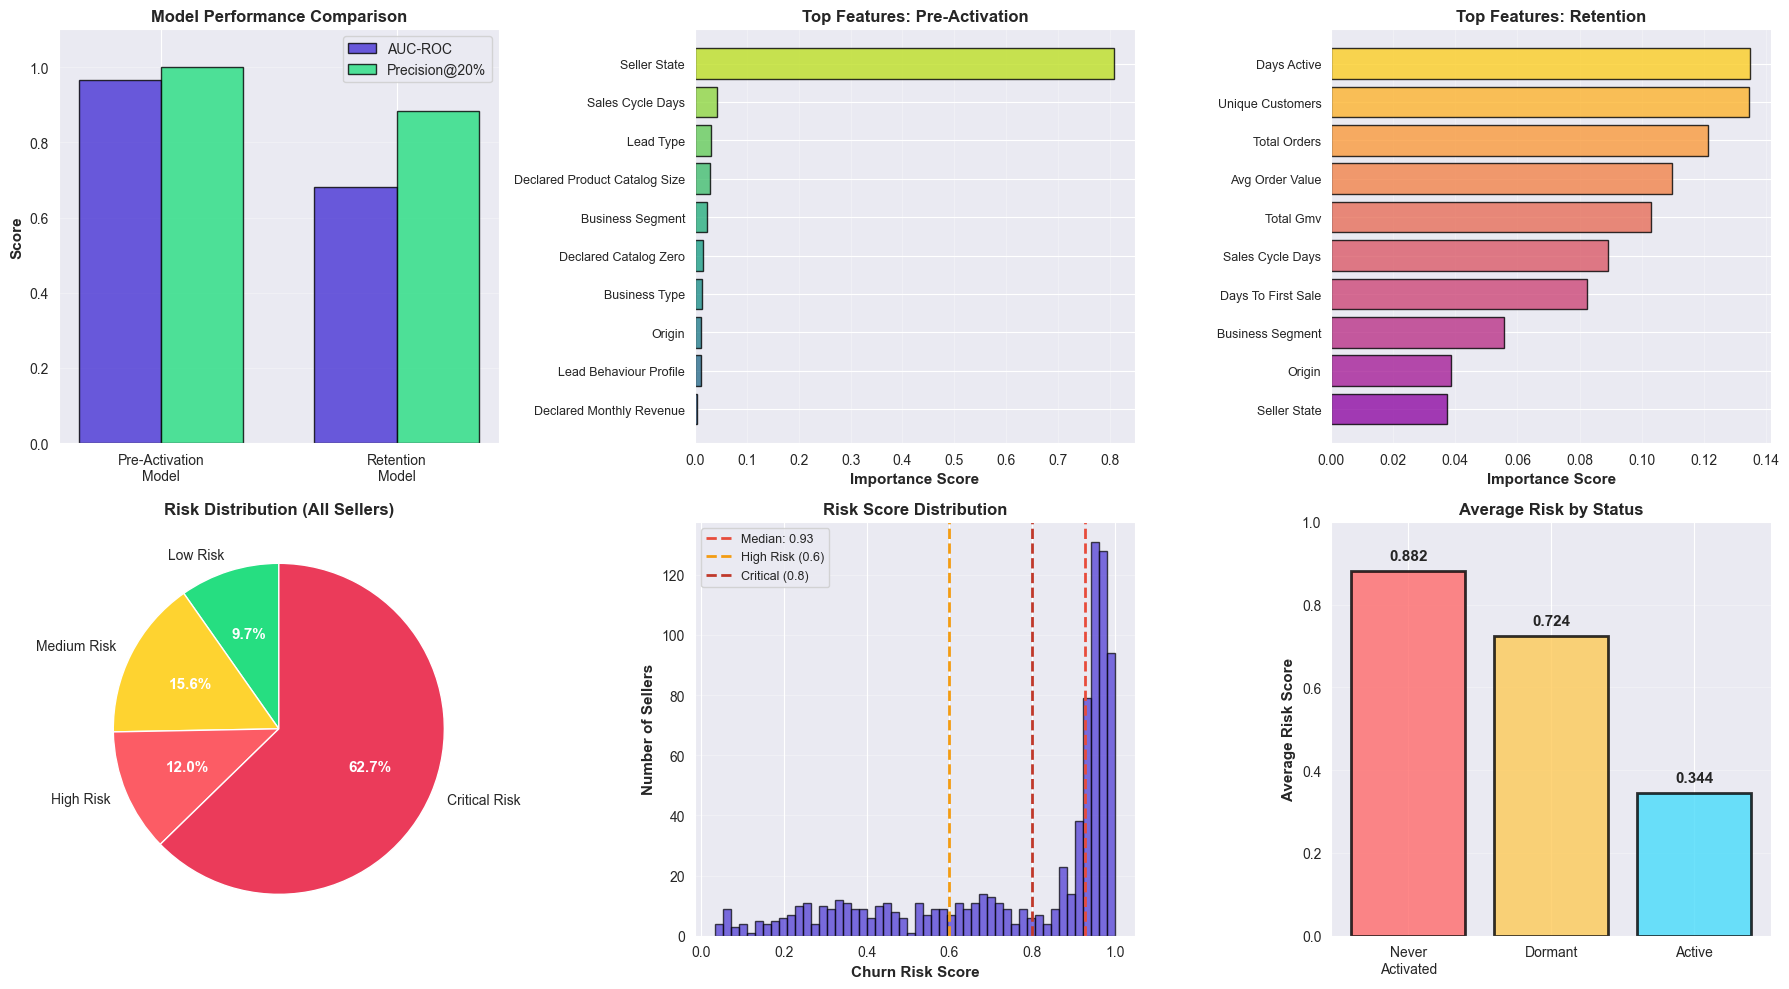

In [21]:
# Create visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Model Performance Comparison
models = ['Pre-Activation\nModel', 'Retention\nModel']
auc_scores = [best_auc_pre, best_auc_active]
precision_scores = [precision_at_20, precision_at_20_active]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, auc_scores, width, label='AUC-ROC', color='#4834d4', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x + width/2, precision_scores, width, label='Precision@20%', color='#26de81', alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('Score', fontsize=11, weight='bold')
axes[0, 0].set_title('Model Performance Comparison', fontsize=12, weight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Feature Importance - Pre-Activation
top_features_pre = feature_importance_pre.head(10).sort_values('Importance')
feature_names_clean = top_features_pre['Feature'].str.replace('_encoded', '').str.replace('_', ' ').str.title()

axes[0, 1].barh(range(len(top_features_pre)), top_features_pre['Importance'], 
                color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features_pre))), 
                alpha=0.8, edgecolor='black')
axes[0, 1].set_yticks(range(len(top_features_pre)))
axes[0, 1].set_yticklabels(feature_names_clean, fontsize=9)
axes[0, 1].set_xlabel('Importance Score', fontsize=11, weight='bold')
axes[0, 1].set_title('Top Features: Pre-Activation', fontsize=12, weight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Feature Importance - Retention
top_features_active = feature_importance_active.head(10).sort_values('Importance')
feature_names_active = top_features_active['Feature'].str.replace('_encoded', '').str.replace('_', ' ').str.title()

axes[0, 2].barh(range(len(top_features_active)), top_features_active['Importance'], 
                color=plt.cm.plasma(np.linspace(0.3, 0.9, len(top_features_active))), 
                alpha=0.8, edgecolor='black')
axes[0, 2].set_yticks(range(len(top_features_active)))
axes[0, 2].set_yticklabels(feature_names_active, fontsize=9)
axes[0, 2].set_xlabel('Importance Score', fontsize=11, weight='bold')
axes[0, 2].set_title('Top Features: Retention', fontsize=12, weight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='x')

# Plot 4: Risk Distribution
risk_counts = model_data['risk_category'].value_counts().sort_index()
colors_risk = ['#26de81', '#fed330', '#fc5c65', '#eb3b5a']

wedges, texts, autotexts = axes[1, 0].pie(
    risk_counts.values,
    labels=risk_counts.index,
    autopct='%1.1f%%',
    colors=colors_risk,
    startangle=90
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_weight('bold')

axes[1, 0].set_title('Risk Distribution (All Sellers)', fontsize=12, weight='bold')

# Plot 5: Risk Score Histogram
axes[1, 1].hist(model_data['overall_churn_risk'].dropna(), bins=50, 
         color='#4834d4', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(model_data['overall_churn_risk'].median(), color='#e74c3c', 
            linestyle='--', linewidth=2, label=f'Median: {model_data["overall_churn_risk"].median():.2f}')
axes[1, 1].axvline(0.6, color='#f39c12', linestyle='--', linewidth=2, label='High Risk (0.6)')
axes[1, 1].axvline(0.8, color='#c0392b', linestyle='--', linewidth=2, label='Critical (0.8)')
axes[1, 1].set_xlabel('Churn Risk Score', fontsize=11, weight='bold')
axes[1, 1].set_ylabel('Number of Sellers', fontsize=11, weight='bold')
axes[1, 1].set_title('Risk Score Distribution', fontsize=12, weight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Plot 6: Risk by Status
status_data = []
for status, label in [('never_activated', 'Never\nActivated'), 
                      ('dormant', 'Dormant'), 
                      ('active', 'Active')]:
    mask = model_data[status] == 1
    if mask.sum() > 0:
        status_data.append({
            'Status': label,
            'Avg_Risk': model_data.loc[mask, 'overall_churn_risk'].mean()
        })

status_df = pd.DataFrame(status_data)
bars = axes[1, 2].bar(status_df['Status'], status_df['Avg_Risk'], 
               color=['#ff6b6b', '#feca57', '#48dbfb'], 
               alpha=0.8, edgecolor='black', linewidth=2)

axes[1, 2].set_ylabel('Average Risk Score', fontsize=11, weight='bold')
axes[1, 2].set_title('Average Risk by Status', fontsize=12, weight='bold')
axes[1, 2].set_ylim(0, 1)
axes[1, 2].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, risk in zip(bars, status_df['Avg_Risk']):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{risk:.3f}', ha='center', va='bottom', fontsize=11, weight='bold')

# save the image
plt.savefig(output_path + 'risk_score_dashboard.png', dpi=300, bbox_inches='tight')


plt.tight_layout()
plt.show()

### STEP 8: Save All Outputs

In [22]:
# Save risk scores for all sellers
risk_scores = model_data[[
    'seller_id', 'business_segment', 'lead_behaviour_profile', 'seller_state',
    'never_activated_risk', 'dormancy_risk', 'overall_churn_risk', 'risk_category',
    'churned', 'never_activated', 'dormant', 'active',
    'total_orders', 'total_gmv'
]].copy()

risk_scores.to_csv('day3_seller_risk_scores.csv', index=False)
print("✓ Saved: day3_seller_risk_scores.csv (all 842 sellers)")

# Save intervention priority list
intervention_priority.to_csv('day3_intervention_priority.csv', index=False)
print("✓ Saved: day3_intervention_priority.csv (top 100 at-risk sellers)")

# Save feature importance
feature_importance_pre.to_csv('day3_feature_importance_preactivation.csv', index=False)
print("✓ Saved: day3_feature_importance_preactivation.csv")

feature_importance_active.to_csv('day3_feature_importance_retention.csv', index=False)
print("✓ Saved: day3_feature_importance_retention.csv")

# Save model performance summary
model_performance = pd.DataFrame({
    'Model': ['Pre-Activation Model', 'Retention Model'],
    'Best_Algorithm': [best_name_pre, best_name_active],
    'AUC_Score': [best_auc_pre, best_auc_active],
    'Precision_at_Top_20%': [precision_at_20, precision_at_20_active],
    'Training_Samples': [len(X_train_pre), len(X_train_active)],
    'Test_Samples': [len(X_test_pre), len(X_test_active)]
})

model_performance.to_csv('day3_model_performance.csv', index=False)
print("✓ Saved: day3_model_performance.csv")

print("\n" + "="*80)
print("DAY 3 ANALYSIS COMPLETE ✓")
print("="*80)
print()
print("Key Achievements:")
print(f"  • Built 2 predictive models (AUC: {best_auc_pre:.3f}, {best_auc_active:.3f})")
print(f"  • Generated risk scores for all 842 sellers")
print(f"  • Identified {len(intervention_list)} at-risk sellers")
print(f"  • Created intervention priority list")
print(f"  • Extracted feature importance for both models")

✓ Saved: day3_seller_risk_scores.csv (all 842 sellers)
✓ Saved: day3_intervention_priority.csv (top 100 at-risk sellers)
✓ Saved: day3_feature_importance_preactivation.csv
✓ Saved: day3_feature_importance_retention.csv
✓ Saved: day3_model_performance.csv

DAY 3 ANALYSIS COMPLETE ✓

Key Achievements:
  • Built 2 predictive models (AUC: 0.965, 0.682)
  • Generated risk scores for all 842 sellers
  • Identified 8 at-risk sellers
  • Created intervention priority list
  • Extracted feature importance for both models
